## End to End Data Science Without Leaving The GPU

AICamp Tech Talk <br>
Speaker: Randy Zwitch <br>
Title: Senior Developer Advocate at [MapD](https://www.mapd.com/) <br>
Date: 2018-07-18 <br>
Twitter: [@randyzwitch](https://twitter.com/randyzwitch)

In [1]:
#pymapd is a DBI-compatible package for connecting to MapD database
#Will return GPU dataframe with connect.select_ipc_gpu method
from pymapd import connect
import pandas as pd
import xgboost
import numpy as np
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

In [2]:
#Default credentials at MapD install
conn = connect(host="localhost", port= 9091, user="mapd", password="HyperInteractive", dbname="mapd")

### 0. Understand data location

In [3]:
#Show all of the tables in database
#We'll use the nyctaxi table, created using code similar to https://github.com/toddwschneider/nyc-taxi-data
conn.get_tables()

['mapd_states',
 'mapd_counties',
 'mapd_countries',
 'nyc_trees_2015_683k',
 'fordgobike_tripdata',
 'flights_2008_7M',
 'nyctaxi']

In [4]:
#Wrapped with pd.DataFrame() for pretty printing
tbl_detail = conn.get_table_details("nyctaxi")
pd.DataFrame(tbl_detail)

,name,type,nullable,precision,scale,comp_param
0,cab_type_id,INT,True,0,0,8
1,vendor_id,STR,True,0,0,8
2,pickup_datetime,TIMESTAMP,True,0,0,32
3,dropoff_datetime,TIMESTAMP,True,0,0,0
4,store_and_fwd_flag,STR,True,0,0,8
5,rate_code_id,INT,True,0,0,16
6,pickup_longitude,FLOAT,True,0,0,0
7,pickup_latitude,FLOAT,True,0,0,0
8,dropoff_longitude,FLOAT,True,0,0,0
9,dropoff_latitude,FLOAT,True,0,0,0


### 1. Getting a data sample

`pygdf` is currently limited to single-GPU use at the library level. This example uses a NVIDIA 1080ti gaming card, which has 11GB GPU RAM. So we'll take a sample of the billion taxi rides, as well as limit to some columns I expect to be useful for modeling.

In [5]:
#pre-process the data, cast to smallest size pygdf will take for memory savings
#cab_type_id, pickup_dow, pickup_hour, passenger_count would all fit in tinyint, but not currently supported in pygdf
query = """select
cast(extract(DOW from pickup_datetime) as smallint) as pickup_dow,
cast(extract(HOUR from pickup_datetime) as smallint) as pickup_hour,
cast(passenger_count as smallint) as passenger_count,
cast(trip_distance as float) as trip_distance,
cast(tip_amount as float) as tip_amount,
cast(total_amount as float) as total_amount,
payment_type,
pickup_boroname,
dropoff_boroname,
color,
temp
from nyctaxi
limit 5000000;
"""

In [6]:
#5mm records as result of query, but no data transferred
#Set device_id = 2 to use open GPUs memory; MapD using device_id = 0 for its own caching
taxi_sample = conn.select_ipc_gpu(query, device_id=2)

### 2. Defining Target: Tip Percentage

For this example, we'll try to predict tip percentage relative to day of week, hour, number of passengers and other data elements from the query above. To do so, we need to calculate the tip percentage from the `tip_amount` and `total_amount` columns.

In [7]:
#This could've been done in the query above, but highlights pandas-like syntax of pygdf
#No data has been transfered at this point, just pygdf taking control of GPU shared memory
taxi_sample["tip_pct"] = taxi_sample["tip_amount"] / taxi_sample["total_amount"]

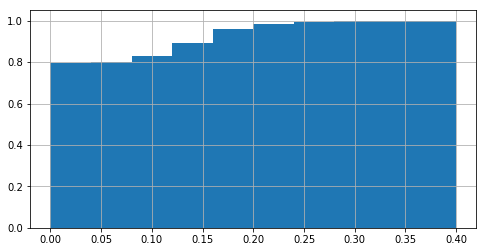

In [8]:
#To visualize the distribution of tip_pct, now we do a CPU RAM transfer to pandas
fig1 = (taxi_sample["tip_pct"]
         .to_pandas()
         .hist(figsize=(8, 4), range=[0, .4], density=True, cumulative=True)
)

plt.show(fig1)

### 3. Data Pre-processing

Parts of code below sourced from https://github.com/h2oai/h2o4gpu/blob/c6684b3408d640c2cb2f7700a0c985184eb67f17/examples/py/goai/GLM.ipynb

In [9]:
#split columns by intended usage
predict_column = set(['tip_pct'])
feature_columns = set(taxi_sample.columns) - set(['tip_amount', 'tip_pct'])
var_num = set(['passenger_count', 'trip_distance', 'temp', 'total_amount'])
var_cat = set(['payment_type', 'pickup_boroname', 'dropoff_boroname', 'color'])
var_cat_num = set(['pickup_dow', 'pickup_hour'])

In [10]:
#Numeric column processing
#change dtype to float64, fill missing values with mean, then scale to 0-1
for col in var_num:
    taxi_sample[col] = (taxi_sample[col]
                        .astype(np.float64)
                        .fillna(taxi_sample[col].mean())
                       )
    assert taxi_sample[col].null_count == 0
    
    std = taxi_sample[col].std()
    # drop near constant columns
    if not np.isfinite(std) or std < 1e-4:
        del taxi_sample[col]
        print('drop near constant', col)
    else:
        taxi_sample[col] = taxi_sample[col].scale()

In [11]:
#Categorical variable processing, do one-hot encoding
#Hour and Day numbers, but categories, so process separate
for col in var_cat_num:
    cats = taxi_sample[col].astype(np.int64).unique()[1:]  # drop first
    taxi_sample = taxi_sample.one_hot_encoding(col, prefix=col, cats=cats)
    del taxi_sample[col]

In [12]:
#change dtype to int64
#weird hack from H2o notebook
for col in var_cat:
    taxi_sample[col] = taxi_sample[col].astype(np.int64)

In [13]:
#Categorical variable processing, do one-hot encoding
for col in var_cat:
    cats = taxi_sample[col].unique()[1:]  # drop first
    taxi_sample = taxi_sample.one_hot_encoding(col, prefix=col, cats=cats)
    del taxi_sample[col]

### 4. Observe Transformed Data

When transforming data (especially using weird float64 hacks!), it's a good idea to check the data before proceeding

In [14]:
taxi_sample.head().to_pandas()

,passenger_count,trip_distance,tip_amount,total_amount,temp,tip_pct,pickup_dow_1,pickup_dow_2,pickup_dow_3,pickup_dow_4,pickup_dow_5,pickup_dow_6,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,pickup_boroname_1,pickup_boroname_2,pickup_boroname_3,pickup_boroname_4,payment_type_1,payment_type_2,payment_type_3,dropoff_boroname_1,dropoff_boroname_2,dropoff_boroname_3,dropoff_boroname_4
0,0.166667,0.0192,0.00,0.015686,0.647696,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.166667,0.0400,1.03,0.023660,0.512195,0.129887,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.166667,0.0280,0.00,0.020044,0.539295,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.000000,0.0206,0.00,0.017429,0.159892,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.333333,0.0470,0.00,0.028758,0.457995,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 5. Create Test/Train Datasets

In [15]:
#All columns need to have same dtype to later convert to matrix
#Convert to float64 to maintain original fidelity
for col in taxi_sample.columns:
    taxi_sample[col] = taxi_sample[col].astype(np.float64)
    
cp = int(.70 * len(taxi_sample))

df_train, df_test = taxi_sample.loc[:cp-1], taxi_sample.loc[cp:]

print('Total number of rows: %d' %(len(taxi_sample)))
print('Training datset has: %d' %(len(df_train)))
print('Test datset has: %d' %(len(df_test)))

Total number of rows: 5000000
Training datset has: 3500000
Test datset has: 1500000


### 6. Hand off to xgboost

In [16]:
#Prepare datasets with predicted column last
X_train = df_train.to_pandas().drop('tip_pct',axis=1)
Y_train = df_train.to_pandas()['tip_pct']
T_train_xgb = xgboost.DMatrix(X_train, Y_train)

X_test = df_test.to_pandas().drop('tip_pct',axis=1)
Y_test = df_test.to_pandas()['tip_pct']
T_test_xgb = xgboost.DMatrix(X_test, Y_test)

In [17]:
#Set xgboost parameters and tree type
params = {"objective": "reg:linear", "booster":"gblinear"}

#Use all the defaults for train here, as to not add excess detail
#In actual usage, grid-search or other means of parameter tuning appropriate
gbm = xgboost.train(dtrain=T_train_xgb, params=params)

In [18]:
#Make predictions using fit model
preds = gbm.predict(T_test_xgb)

In [19]:
#See explained variance
print(explained_variance_score(preds,Y_test))

0.16915474212233894


In [20]:
#Visualize results
results = pd.concat([pd.Series(preds).reset_index(drop=True), Y_test.reset_index(drop=True)], axis = 1)
results.columns = ["predicted", "actual"]
results["diff"] = (results["predicted"] - results["actual"])/results["actual"]

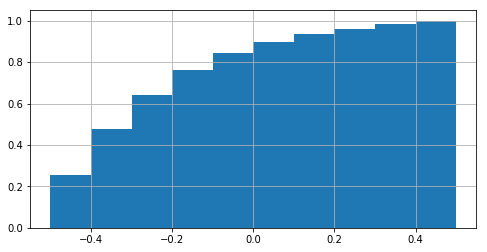

In [21]:
#Percentage missed for each tip level
#Negative means that actual > predicted: 80% of time, predicted tip was too low
plt2 = results["diff"].hist(range=[-0.5, .5], density=True, cumulative=True, figsize=(8, 4))